# Cell-to-Spot Alignment of Mouse Brain Coronal Sections with Mismatched Resolution

In this experiment, we align an adult mouse brain coronal section (Fresh Frozen) from **10x Genomics Visium**  
(https://www.10xgenomics.com/datasets/adult-mouse-brain-coronal-section-fresh-frozen-1-standard)  
to a **Xenium** replicate (Mouse Brain Replicate 2)  
(https://www.10xgenomics.com/datasets/fresh-frozen-mouse-brain-replicates-1-standard).  

This scenario highlights GALA's ability to perform **cell-to-spot alignment** when the source (high-resolution single-cell data) and target (lower-resolution spatial transcriptomics) datasets have **mismatched spatial resolutions**.



In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import time 
import torch
import matplotlib.gridspec as gridspec

import os
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.patches import Rectangle,ConnectionPatch


import warnings
for cat in [FutureWarning, DeprecationWarning]:
    warnings.filterwarnings("ignore", category=cat)

# data loading path
data_path = os.path.expanduser('../Data/MBCS')  # Update this path to your data directory  
results_path = os.path.expanduser('./Results/tutorials')  # Directory to save results
os.makedirs(results_path, exist_ok=True)

# Data Loading and Gene Selection

- **Load processed datasets:**  
  - `source`: Xenium mouse brain replicate  
  - `target`: Visium mouse brain coronal section  

- **Gene selection:**  
  - Identify genes shared between source and target datasets.  
  - Select the top 3 informative genes from the source dataset for alignment.

In [2]:
from GALA.utils import top_p_genes
### Load processed data
source = sc.read_h5ad(os.path.join(data_path, "Mouse_Brain_Xenium_processed.h5ad")) 
target = sc.read_h5ad(os.path.join(data_path, "Mouse_Brain_Visium_processed.h5ad"))  


### Gene selection
shared_gene_names = target.var_names.intersection(source.var_names)
source = source[:,shared_gene_names]
target = target[:,shared_gene_names]
gene_names_to_keep = top_p_genes(source,shared_gene_names,p = 3)

## Visualization of Raw Data

This plot shows the spatial distribution of cells and spots in the **Xenium (source)** and **Visium (target)** datasets.  

- Each point represents a cell (Xenium) or spot (Visium).  
- Colour encodes **total gene expression counts** (lighter colours indicate higher expression).  
- The figure allows a quick visual inspection of **spatial coverage and resolution differences** between the two datasets.

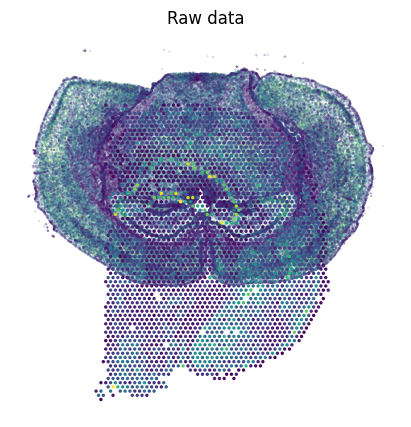

In [3]:
spatiali = source.obsm['spatial']
spatialj = target.obsm['spatial']
ci = source.obs['total_counts']
cj = target.obs['total_counts']

fig,ax = plt.subplots(figsize = (6,5))
ax.scatter(spatiali[:,0],spatiali[:,1], s= 0.01, alpha=1,c = ci,cmap='viridis')
ax.scatter(spatialj[:,0],spatialj[:,1],s = 2,alpha=1,c = cj,cmap='viridis')
ax.invert_yaxis()
ax.set_title('Raw data')
ax.set_aspect('equal')
ax.axis('off')
plt.show()


To enable alignment on a **common spatial grid**, we rasterize both source and target datasets:

- **Source (Xenium cells)**: rasterized at **30 µm resolution** to account for the finer spatial sampling of single cells.  
- **Target (Visium spots)**: rasterized at **approximately 1 unit raster resolution** ( corresponding to low-resolution scale) to match the spot-based grid.  

This process converts the **sparse cell and spot coordinates** into **dense, image-like representations**, enabling GALA to efficiently compute multimodal correspondences and perform diffeomorphic alignment.

In [4]:
from GALA.utils import rasterize_channel
dx = 30.0
### source
X = np.array(source[:,gene_names_to_keep].X.todense())
gi = np.array(source.X.sum(axis=1))
si = np.concatenate([X, gi], axis=1)
XI,YI,I = rasterize_channel(spatiali[:,0], spatiali[:,1], si,dx = dx)
### target
X = np.array(target[:,gene_names_to_keep].X.todense())
gj = np.array(target.X.sum(axis = 1))
sj = np.concatenate([X, gj], axis=1)
XJ,YJ,J = rasterize_channel(spatialj[:,0], spatialj[:,1], sj,dx = dx)

xI = [YI,XI]
xJ = [YJ,XJ]


0 of 149023
10000 of 149023
20000 of 149023
30000 of 149023
40000 of 149023
50000 of 149023
60000 of 149023
70000 of 149023
80000 of 149023
90000 of 149023
100000 of 149023
110000 of 149023
120000 of 149023
130000 of 149023
140000 of 149023
149022 of 149023
0 of 2634
2633 of 2634


Visualize the rasterized gene expression and total counts for both datasets:

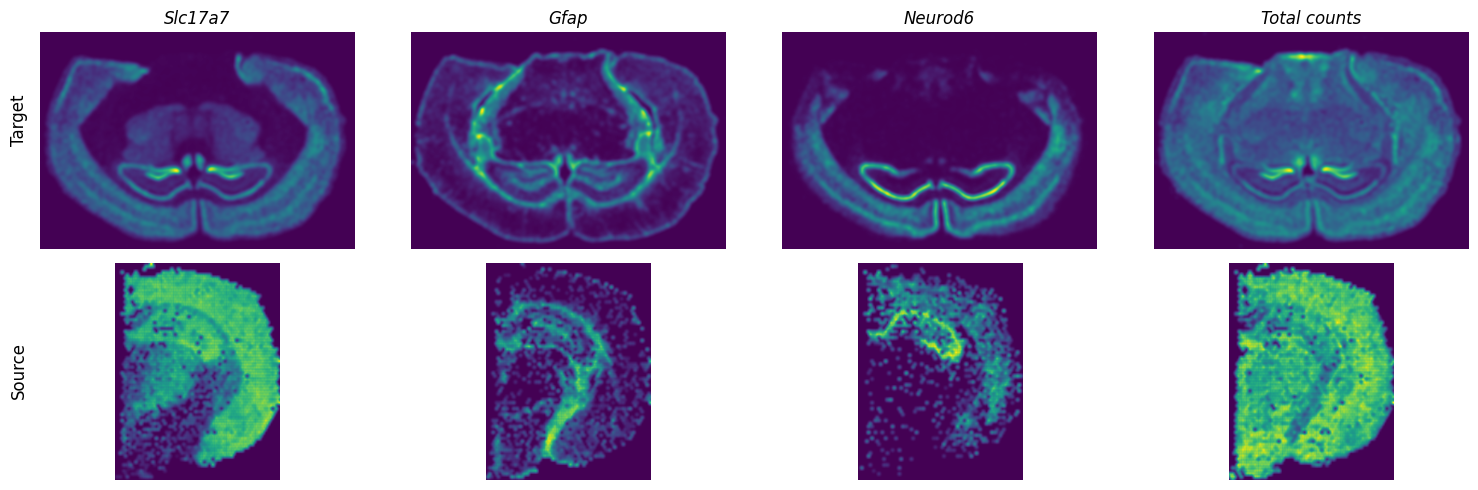

In [5]:
colnames =  gene_names_to_keep.append(pd.Index(['Total counts']))
fig, axs = plt.subplots(2, 4,figsize=(15, 5))
fig.text(0.01, 0.75, 'Target', fontsize=12, rotation='vertical',
               verticalalignment='center', horizontalalignment='center')

fig.text(0.01, 0.25, 'Source', fontsize=12, rotation='vertical',
               verticalalignment='center', horizontalalignment='center')

for i in range(4):
    axs[0, i].imshow(I[i])
    axs[0, i].set_title(colnames[i], fontsize=12,fontstyle = 'italic')
    axs[1, i].imshow(J[i])
    axs[0, i].axis('off')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

# Run GALA

In [6]:
from GALA.gala import gala
from GALA.utils import to_cpu

rIy = xI[0].max() - xI[0].min()
rIx = xI[1].max() - xI[1].min()
rJy = xJ[0].max() - xJ[0].min()
rJx = xJ[1].max() - xJ[1].min()
sx_range = rIx / rJx if rIx > rJx else rJx / rIx  
sy_range = rIy / rJy if rIy > rJy else rJy / rIy
gene_space = [
    {'low': 180, 'high': 180},     # angle
    {'low': 0.01, 'high': (sy_range+0.1)},     # sy
    {'low': 0.01, 'high': (sx_range+0.1)},     # sx
    {},     # ty
    {},     # tx
]
params = {'num_generations' : 1000,
          'num_iterations': 5000,
          'num_repeats': 2,
          'epV': 10.0,
          'a': 300,
          'sigmaR':2e5,
          'sigmaM': I.std(),
          'sigmaB': 0.1,
          'random_seed': 42
          }

start = time.time()
resu = gala(xI,I,xJ,J,gene_space = gene_space, **params)
print('Alignment Runtime: ' + str(time.time() - start)) 


# save resu and copy results to CPU if gala runs on GPU.
if torch.cuda.is_available():
    resu = to_cpu(resu)
    
# with open(os.path.join(results_path, "mbs.pkl"), 'wb') as f:
#     pickle.dump(resu, f)

Iteration 1 of 2
Generation = 200
Fitness    = 5.542235601751766e-05
Change     = 5.542235601751766e-05
Generation = 400
Fitness    = 5.54458173119818e-05
Change     = 2.3461294464143835e-08
Generation = 600
Fitness    = 5.552922793234808e-05
Change     = 8.341062036628066e-08
Generation = 800
Fitness    = 5.553168145197599e-05
Change     = 2.453519627909791e-09
Generation = 1000
Fitness    = 5.553233535464348e-05
Change     = 6.539026674870713e-10
Best transformation: angle=180.00, sx=1.40, sy=1.35, tx=-3287.88, ty=58.35
0 of 5000
500 of 5000
1000 of 5000
1500 of 5000
2000 of 5000
2500 of 5000
3000 of 5000
3500 of 5000
4000 of 5000
4500 of 5000
4999 of 5000
Iteration 2 of 2
Generation = 200
Fitness    = 5.542235601751766e-05
Change     = -1.0997933712582136e-07
Generation = 400
Fitness    = 5.54458173119818e-05
Change     = 2.3461294464143835e-08
Generation = 600
Fitness    = 5.552922793234808e-05
Change     = 8.341062036628066e-08
Generation = 800
Fitness    = 5.553168145197599e-05
C

# Result Analysis
Load previously saved results if we choose to skip running the alignment optimization.

In [3]:
torch.set_default_device('cpu')
# load results
with open(os.path.join(results_path,'mbs.pkl'), 'rb') as f:
   resu = pickle.load(f)

## Convergence of Objective Function 

Enery value before alignment: 186358.17609328614; Enery value after alignment: 84836.18006809312


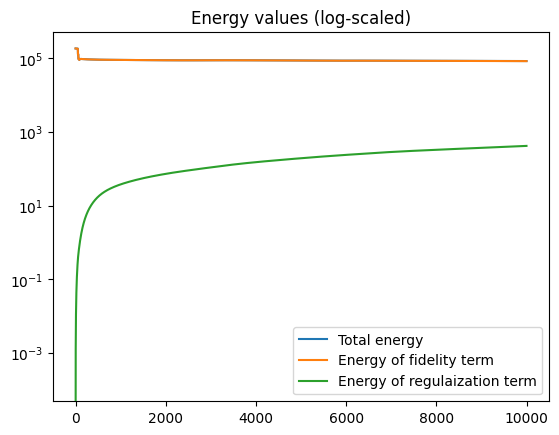

Initial energy for Total energy 186358.17609328614, fidelity term 186358.17609328614, and regularisation term 0.0
Final energy for Total energy 84836.18006809312, fidelity term 84417.7060662969, and regularisation term 418.474001796222


In [4]:
### Convergence of objective function 
E = resu['E']
print(f'Enery value before alignment: {E[0][0]}; Enery value after alignment: {E[-1][0]}')

fig, ax = plt.subplots()
ax.plot(E)
ax.legend(['Total energy','Energy of fidelity term','Energy of regulaization term'])
ax.set_yscale('log')
ax.set_title('Energy values (log-scaled)')
plt.show()

print(f'Initial energy for Total energy {E[0][0]}, fidelity term {E[0][1]}, and regularisation term {E[0][2]}')
print(f'Final energy for Total energy {E[-1][0]}, fidelity term {E[-1][1]}, and regularisation term {E[-1][2]}')

## Aligned slices

This figure compares **source and target slices** at different stages of alignment:

1. **Unaligned slices (left):** Raw spatial coordinates of the source (Xenium) and target (Visium) datasets.  
2. **Affine transformed slices (middle):** Source after global affine transformation via GA.  
3. **GALA aligned slices (right):** Source after full GALA alignment, including diffeomorphic mapping.

- **Color intensity:** Total counts per cell/spot.  
- The comparison highlights how GALA improves local correspondence beyond simple affine alignment.

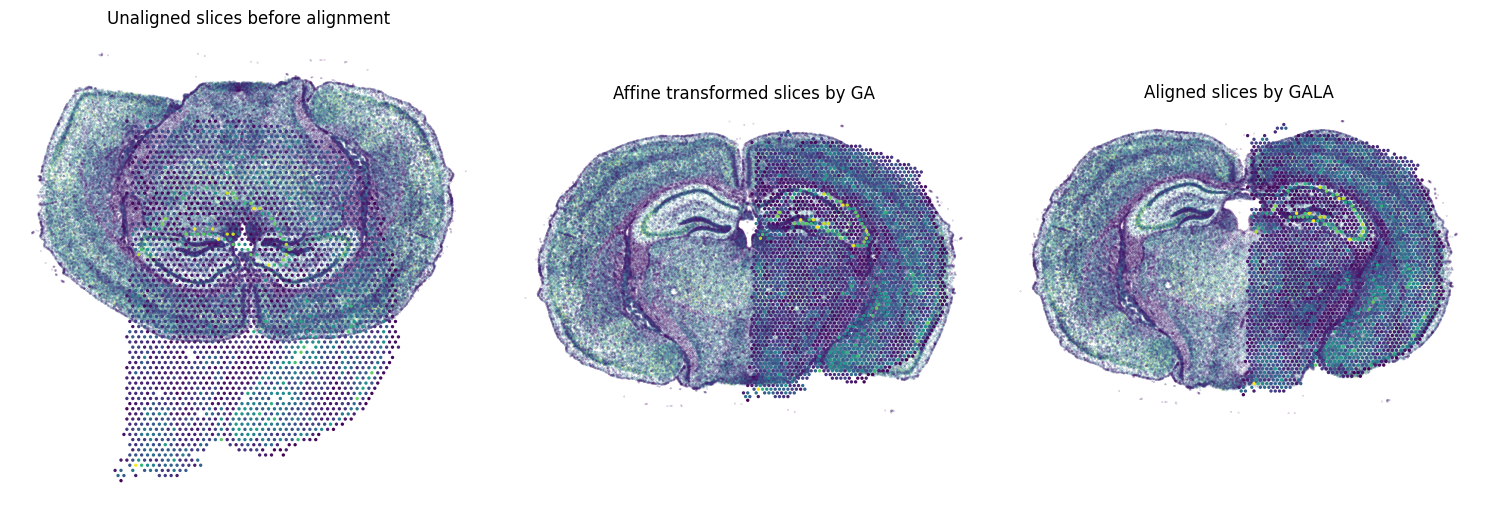

In [9]:
from GALA.utils import alignedada
ps1 = 0.01
ps2 = 2
alpha1 = 1
alpha2 = 1
fig  = plt.figure(figsize = (15,5))
gs = gridspec.GridSpec(1,3)
###
### Unaligned data
###
ax0 = fig.add_subplot(gs[:,0])
ax0.scatter(spatiali[:,0],spatiali[:,1], s= ps1, alpha= alpha1,c = ci,cmap='viridis')
ax0.scatter(spatialj[:,0],spatialj[:,1],s= ps2, alpha= alpha2,c = cj,cmap='viridis')
ax0.set_title('Unaligned slices before alignment')
ax0.axis('off')
ax0.invert_yaxis()
ax0.set_aspect('equal') 

###
### Affine transformed data
###
A = resu['A']
L = A[:2,:2].numpy()
T = A[:2,-1].numpy()
affine = np.dot(L,[spatiali[:,1], spatiali[:,0]]) + np.array([T[0],T[1]])[:,np.newaxis]
spatial0 = np.stack([affine[1, :], affine[0, :]], axis=1)


ax2 = fig.add_subplot(gs[0,1])
ax2.scatter(spatial0[:,0],spatial0[:,1], s= ps1, alpha= alpha1,c = ci,cmap='viridis')
ax2.scatter(spatialj[:,0],spatialj[:,1],s= ps2, alpha= alpha2,c = cj,cmap='viridis')
ax2.invert_yaxis()
ax2.set_title('Affine transformed slices by GA')
ax2.axis('off')
ax2.set_aspect('equal') 

###
### Aligned data
###
aligned_source = alignedada(resu,source)
spatial = aligned_source.obsm['aligned']
ax2 = fig.add_subplot(gs[0,2])
ax2.scatter(spatial[:,0],spatial[:,1], s= ps1, alpha= alpha1,c = ci,cmap='viridis')
ax2.scatter(spatialj[:,0],spatialj[:,1],s= ps2, alpha= alpha2,c = cj,cmap='viridis')
ax2.invert_yaxis()
ax2.set_title('Aligned slices by GALA')
ax2.axis('off')
ax2.set_aspect('equal') 


plt.tight_layout()
plt.show()


## Visualization of Alignment Components

We first compute the **matching probabilities** $P_M$ to quantify how well each cell in the source aligns with the target spots.  
These probabilities provide insight into which regions of the source and target are most confidently matched.

Matching probabilities: tensor([0.5767, 0.4233], dtype=torch.float64)


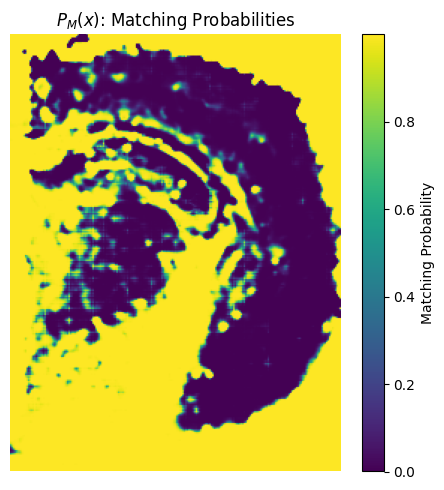

In [6]:
### Matching and Background Probabilities
PM = resu['WM'].cpu()
PB = resu['WB'].cpu()

P = torch.stack((PM,PB))
pi = torch.sum(P,dim=(1,2))
pi += torch.max(pi)*1e-6
pi /= torch.sum(pi)
print('Matching probabilities:', pi)

fig,ax = plt.subplots(figsize = (6,5))
im = ax.imshow(PM)
ax.set_title(r'$P_M(x)$: Matching Probabilities')
ax.axis('off')
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Matching Probability')  

plt.tight_layout()
plt.show()

Next, we compute the **diffeomorphic mapping** \(\phi^v(A(x))\), which transforms the source coordinates to the target space.  
This mapping allows visualization of how the cell locations in the source dataset are deformed to match the spatial layout of the target spots.

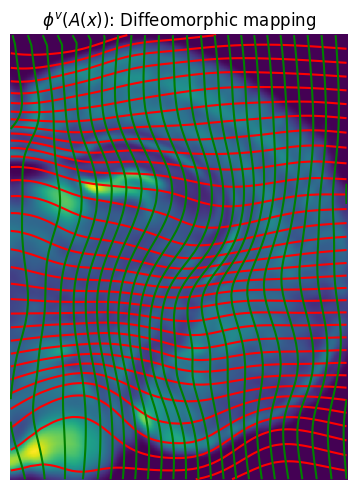

In [11]:
from GALA.utils import build_transform, transform_image_source_to_target,transform_image_target_to_source
### Phi mapping: source to target
xv = resu['xv']
v = resu['v']
A = resu['A']
xI = [YI,XI]
xJ = [YJ,XJ]
xI = [torch.as_tensor(x,device = 'cpu') for x in xI]
xJ = [torch.as_tensor(x,device = 'cpu') for x in xJ]
def extent_from_x(xJ):
    dJ = [x[1]-x[0] for x in xJ]
    extentJ = ( (xJ[1][0] - dJ[1]/2.0).item(),
               (xJ[1][-1] + dJ[1]/2.0).item(),
               (xJ[0][-1] + dJ[0]/2.0).item(),
               (xJ[0][0] - dJ[0]/2.0).item())
    return extentJ

### Forward
phii = build_transform(xv,v,A,torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1))
aI = I[3]
aI = aI[None,...]
phiI = transform_image_source_to_target(xv,v,A,xI,aI,torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1))
extentJ = extent_from_x((YJ,XJ))


fig,ax = plt.subplots(figsize=(6, 5))
ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels= np.arange( phii.min(), phii.max(), 200)  )
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels= np.arange( phii.min(), phii.max(), 200))
ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent = extentJ)
ax.set_title(r'$\phi^v(A(x))$: Diffeomorphic mapping')
ax.axis('off')

plt.tight_layout()
plt.show()


## Inverse Diffeomorphic Mapping $(\phi^v(A(x)))^{-1}$

Here we visualise the **inverse mapping** from target back to source:

- Red and green contours indicate the x- and y-displacement components of the inverse mapping.  
- The overlayed image shows how the target intensities or expression profiles are warped back into the source coordinate frame.  

This demonstrates that GALA can compute both forward and backward diffeomorphic maps for accurate cell-to-cell registration.

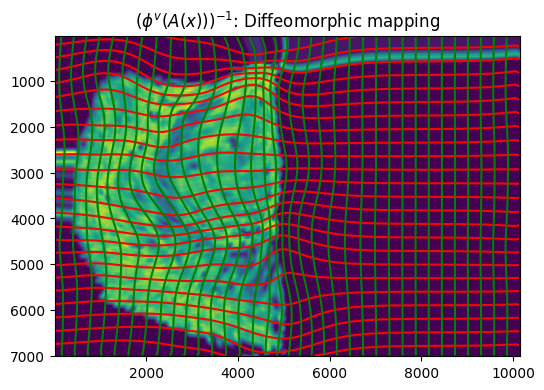

In [12]:
from GALA.utils import transform_image_target_to_source
### Backforwd
phij = build_transform(xv,v,A,torch.stack(torch.meshgrid(*xI,indexing='ij'),-1),forward  = True)
aJ = J[3]
aJ = aJ[None,...]
phiJ = transform_image_target_to_source(xv,v,A,xJ,aJ,torch.stack(torch.meshgrid(*xI,indexing='ij'),-1))
extentI = extent_from_x((YI,XI))

###
### Plots
###
fig,ax = plt.subplots(figsize=(6, 5))
ax.contour(XI,YI,phij[...,0],colors='r',linestyles='-',
            levels= np.arange( phij.min(), phij.max(), 400)  )
ax.contour(XI,YI,phij[...,1],colors='g',linestyles='-',
           levels= np.arange( phij.min(), phij.max(), 400))
ax.imshow(phiJ.permute(1,2,0)/torch.max(phiJ),extent = extentI)
ax.set_title(r'$(\phi^v(A(x)))^{-1}$: Diffeomorphic mapping')
#ax.axis('off')
plt.show()


Plot of alignment by the inverse of diffeomorphic mapping that aligns spot-level slice (target) to cell-resolved slice (source).

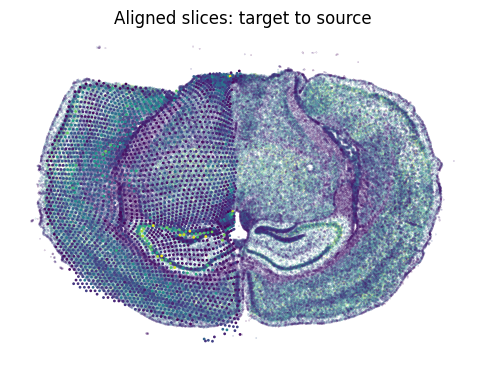

In [13]:
from GALA.utils import transform_points_target_to_source

pointsJ = transform_points_target_to_source(xv,v,A,spatialj[:,[1,0]])
pointsJ = pointsJ[:,[1,0]].numpy()

fig,ax = plt.subplots(figsize = (6,5))
ax.scatter(spatiali[:,0],spatiali[:,1],s= ps1, alpha= alpha1,c = ci,cmap='viridis')
ax.scatter(pointsJ[:,0],pointsJ[:,1],s= 1, alpha= 1,c = cj,cmap='viridis')
ax.set_title('Aligned slices: target to source')
ax.axis('off')
ax.invert_yaxis()
ax.set_aspect('equal') 
plt.show()